In [1]:
import kornia
import robustness
import torch as ch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from robustness.model_utils import make_and_restore_model

In [2]:
from robustness import datasets

In [3]:
from logantools import Image

In [4]:
imn = datasets.ImageNet(data_path='/scratch/engstrom_scratch/imagenet/')

In [5]:
train_loader, _ = imn.make_loaders(1, 1, data_aug=False, subset_type='first')

==> Preparing dataset imagenet..


In [6]:
model, checkpoint = make_and_restore_model(arch='resnet18',
    dataset=imn, resume_path='/data/theory/robustopt/engstrom/store/spatial/random_30/checkpoint.pt.best', parallel=False)

=> loading checkpoint '/data/theory/robustopt/engstrom/store/spatial/random_30/checkpoint.pt.best'
=> loaded checkpoint '/data/theory/robustopt/engstrom/store/spatial/random_30/checkpoint.pt.best' (epoch 336)


In [7]:
from robustness.attack_steps import Spatial

In [8]:
grid_attacker = Spatial('grid', 30)
rand_attacker = Spatial('random', 30)

In [9]:
def correcter(inp):
    target = y.repeat([inp.shape[0]])
    return calc_correct(inp, target)

def calc_correct(inp, target):
    inp = model.normalizer(inp)
    out = model(inp, target=target)

In [10]:
from tqdm import tqdm_notebook

In [11]:
random_attack_args = {
    'spatial_constraint': '30',
    'tries':10,
    'use_best': True,
    'attack_type': 'random'
}

grid_attack_args = {
    'spatial_constraint': '30',
    'tries':1,
    'use_best': True,
    'attack_type': 'grid'
}

for i, (x, y) in tqdm_notebook(enumerate(train_loader)):
    x = x.cuda()
    y = y.cuda()

    rand_logits, rand_img = model(x, target=y, make_adv=True, **random_attack_args)
    rand_corr = rand_logits.argmax(dim=1) == y

    grid_logits, grid_img = model(x, target=y, make_adv=True, **grid_attack_args)
    grid_corr = grid_logits.argmax(dim=1) == y
    
    if not rand_corr[0] and grid_corr[0]:
        break

KeyboardInterrupt: 

In [ ]:
Image(rand_img).show()

In [ ]:
Image(x).show()

In [13]:
with ch.no_grad():
    _, (x,y) = next(enumerate(train_loader))
    worst, every = grid_attacker.step(x, None, losser=losser)

In [73]:
calc_correct(worst, y)

tensor([0], device='cuda:0', dtype=torch.uint8)

In [28]:
import random

328


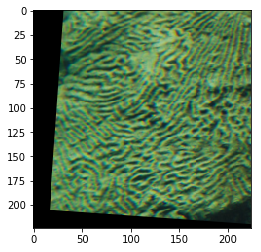

In [48]:
# Image(x).show()
# Image(worst).show()
sel = random.randint(0, every.shape[0]-1)
print(sel)
Image(every[sel:sel+1]).show()